In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'max-rate-submit'
DISK_CONFIG = 'hdd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Max Rate Submit on HDDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would issue the writes as quickly as possible; i.e. immediately after a thread's write would complete, it would issue the next write. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 8 vCPUs
 - 128 GB of RAM
 - Traditional Magnetic Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

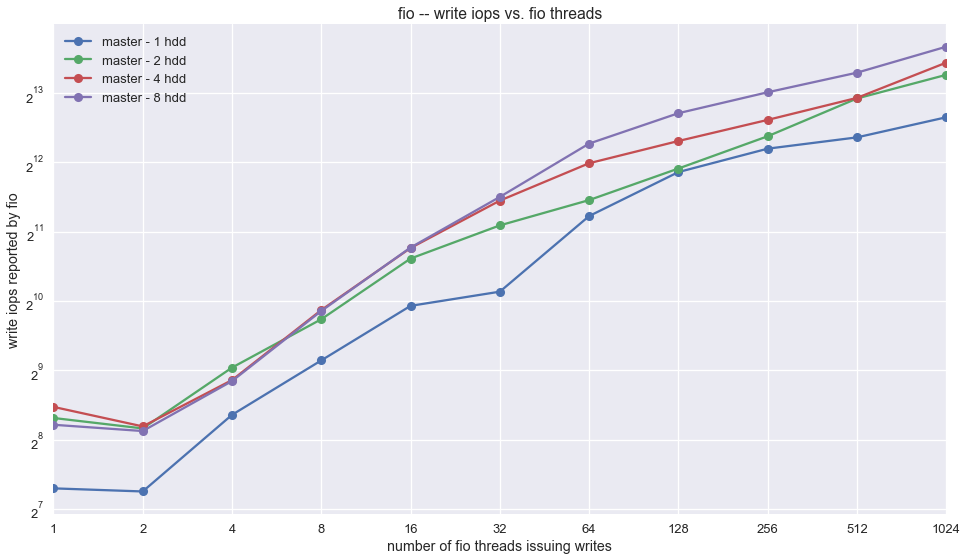

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,157.056196,317.617452,354.871504,296.775269
2,152.257957,286.049961,291.904143,278.691530
4,327.706587,525.778178,464.013731,459.404060
8,565.100738,853.148019,935.139819,926.589913
16,975.229465,1565.765135,1739.792687,1747.925207
32,1123.950420,2181.616704,2795.147395,2900.864870
64,2394.757890,2810.146618,4063.383918,4946.037830
128,3719.092514,3853.802826,5075.007081,6703.170557
256,4700.711086,5322.191690,6268.488907,8265.704344
512,5262.973819,7765.503811,7814.003830,10054.937737


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

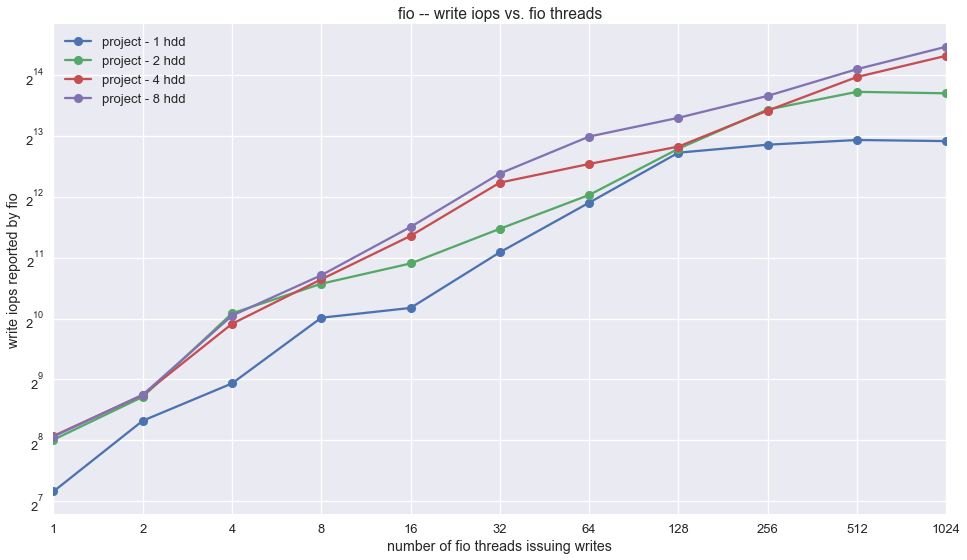

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,142.904758,257.545708,268.895518,267.058804
2,319.812013,419.888674,429.030914,429.935669
4,489.250358,1086.362349,964.667256,1058.912714
8,1034.031065,1523.074615,1601.206546,1678.205363
16,1156.023645,1918.774789,2626.529116,2908.737896
32,2179.195760,2847.915208,4818.343915,5344.954587
64,3833.947048,4186.155410,5959.835342,8143.418991
128,6777.411184,7088.752665,7264.909270,10082.176485
256,7421.395380,11077.739458,10948.723075,12942.831473
512,7831.444028,13551.033302,16048.370172,17546.792378


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

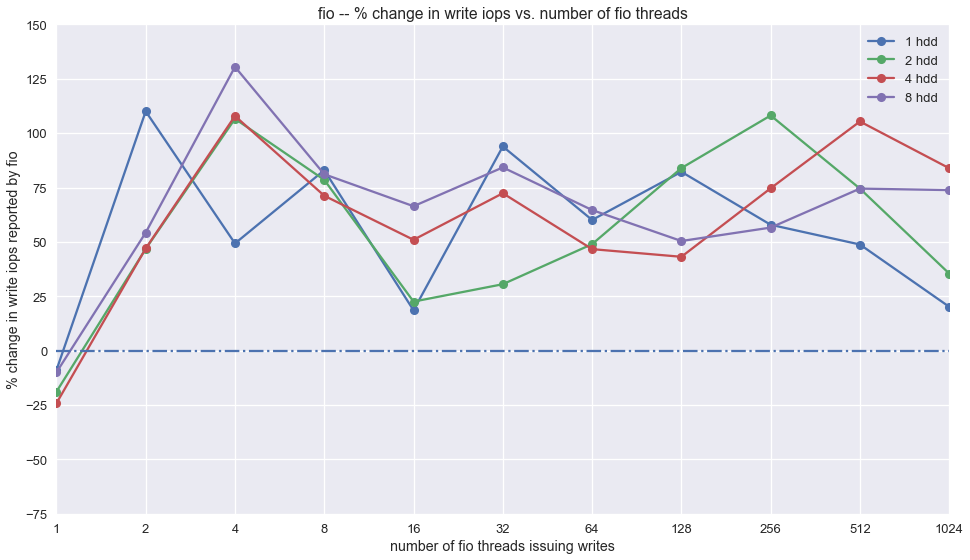

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 hdd,2 hdd,4 hdd,8 hdd
1,-9.010430,-18.913238,-24.227357,-10.013120
2,110.046174,46.788579,46.976644,54.269371
4,49.295247,106.619901,107.896274,130.497030
8,82.981723,78.524076,71.226432,81.116300
16,18.538630,22.545505,50.967936,66.410890
32,93.887179,30.541502,72.382463,84.253829
64,60.097481,48.965730,46.671726,64.645303
128,82.232928,83.941758,43.150722,50.409070
256,57.878143,108.142436,74.662877,56.584738
512,48.802641,74.502951,105.379605,74.509210


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

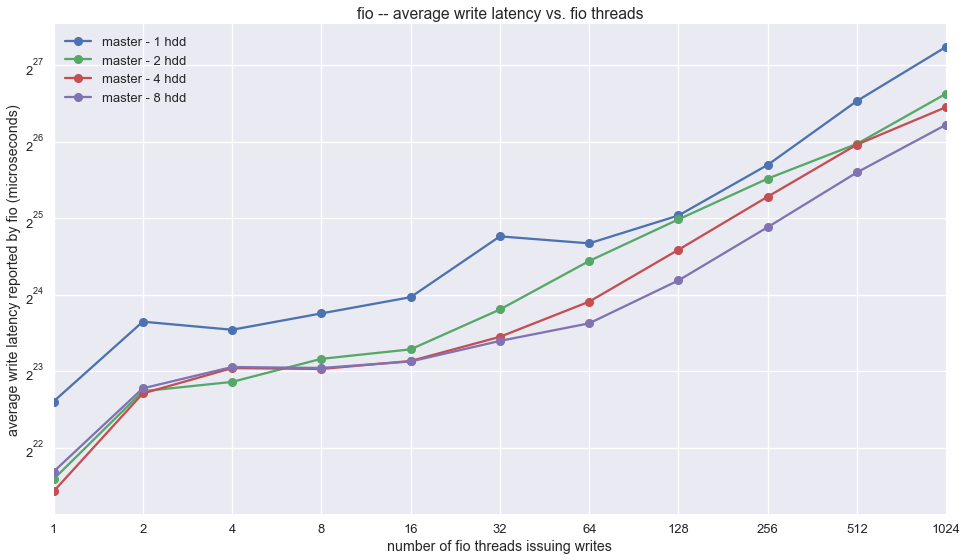

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,6.364775e+06,3.146247e+06,2.815842e+06,3.367425e+06
2,1.313247e+07,6.988959e+06,6.848906e+06,7.173612e+06
4,1.220375e+07,7.605586e+06,8.618157e+06,8.704641e+06
8,1.415424e+07,9.374954e+06,8.552882e+06,8.630967e+06
16,1.640053e+07,1.021622e+07,9.194544e+06,9.151641e+06
32,2.846676e+07,1.466522e+07,1.144644e+07,1.102891e+07
64,2.672066e+07,2.277048e+07,1.574757e+07,1.293748e+07
128,3.440446e+07,3.320703e+07,2.521581e+07,1.909093e+07
256,5.445176e+07,4.807111e+07,4.082116e+07,3.095282e+07
512,9.723398e+07,6.588488e+07,6.546715e+07,5.087114e+07


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

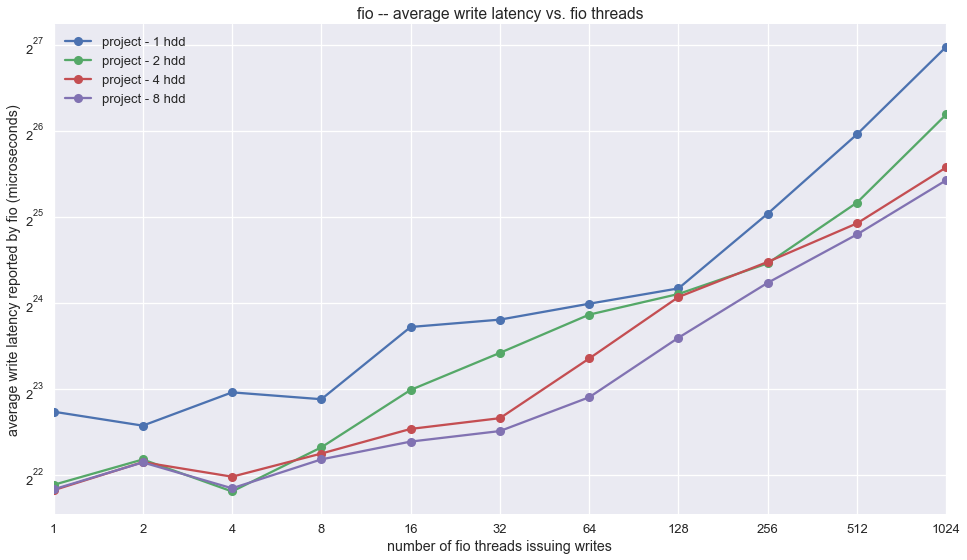

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,6.995521e+06,3.880602e+06,3.716670e+06,3.742315e+06
2,6.251481e+06,4.761048e+06,4.659428e+06,4.649641e+06
4,8.173606e+06,3.679683e+06,4.144205e+06,3.774626e+06
8,7.734382e+06,5.250175e+06,4.993849e+06,4.764659e+06
16,1.383803e+07,8.336109e+06,6.089337e+06,5.498569e+06
32,1.468132e+07,1.123400e+07,6.639270e+06,5.985005e+06
64,1.668933e+07,1.528501e+07,1.073624e+07,7.856911e+06
128,1.888196e+07,1.805079e+07,1.761502e+07,1.269297e+07
256,3.447989e+07,2.310250e+07,2.337332e+07,1.975472e+07
512,6.532686e+07,3.769212e+07,3.188572e+07,2.916353e+07


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

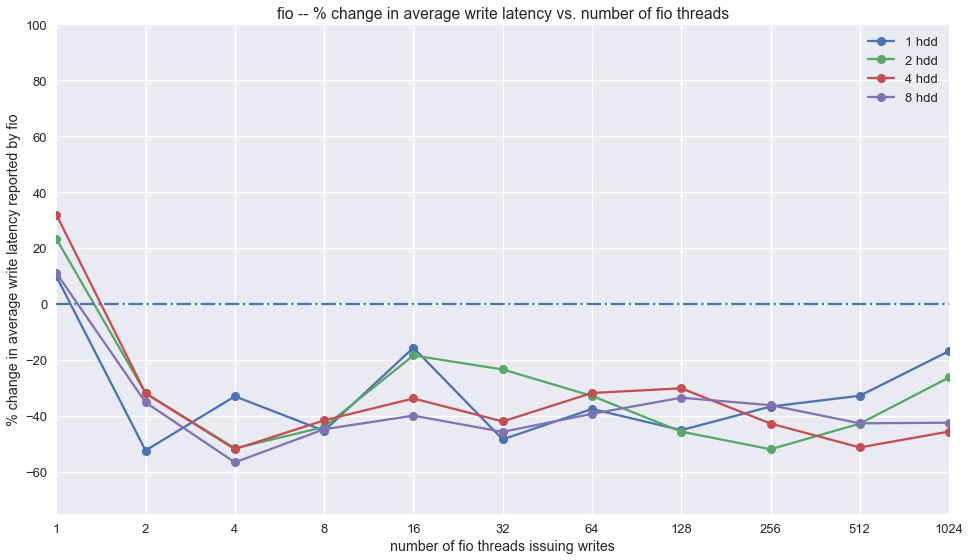

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 hdd,2 hdd,4 hdd,8 hdd
1,9.909953,23.340673,31.991452,11.132822
2,-52.396746,-31.877572,-31.968287,-35.184096
4,-33.023821,-51.618679,-51.913102,-56.636624
8,-45.356428,-43.997861,-41.612092,-44.795767
16,-15.624466,-18.403209,-33.772276,-39.917127
32,-48.426439,-23.396932,-41.997073,-45.733478
64,-37.541460,-32.873574,-31.822887,-39.270180
128,-45.117695,-45.641656,-30.142978,-33.513083
256,-36.678103,-51.940987,-42.742155,-36.177969
512,-32.814782,-42.790941,-51.295091,-42.671751


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

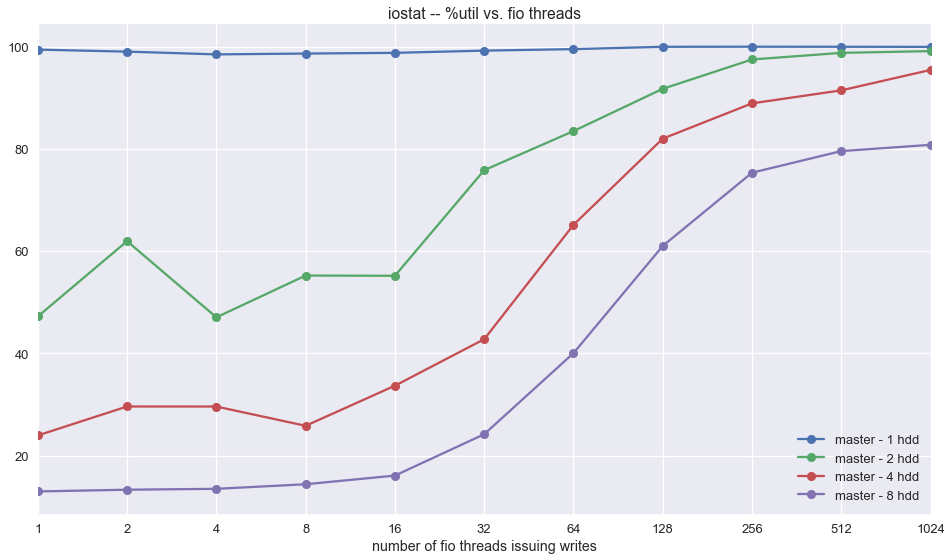

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,99.410909,47.218364,23.949091,12.989091
2,99.018182,61.949091,29.609273,13.330909
4,98.480000,47.047273,29.601091,13.505455
8,98.640000,55.221818,25.832727,14.400000
16,98.778182,55.175091,33.674364,16.094545
32,99.214545,75.827818,42.770909,24.181818
64,99.505455,83.476364,65.137273,40.043636
128,99.963636,91.745455,81.999636,61.013636
256,99.982000,97.483636,88.900727,75.338909
512,99.967455,98.775455,91.444909,79.562727


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

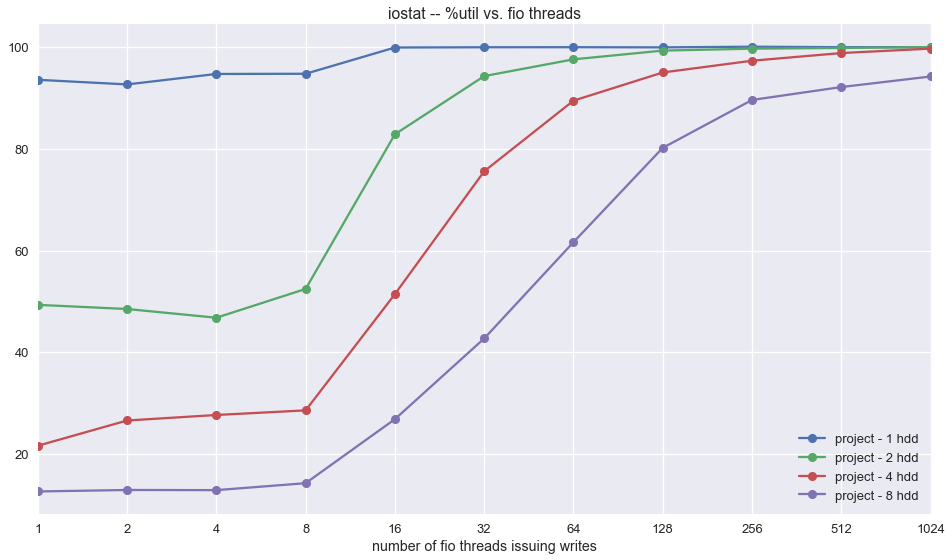

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,93.578182,49.316364,21.607273,12.618182
2,92.669091,48.501818,26.574545,12.909091
4,94.727273,46.785455,27.658182,12.880000
8,94.763636,52.443636,28.567273,14.247273
16,99.927273,82.865455,51.425455,26.836364
32,99.978182,94.305455,75.585455,42.708182
64,99.989091,97.600000,89.476364,61.643636
128,99.956364,99.320182,95.018182,80.196364
256,100.087273,99.694545,97.328182,89.612182
512,99.992727,99.837636,98.837455,92.152727
